# Machine Learning (ML) Exploratory Data Analysis

The intent of this notebook is three-fold:
* First an Exploratory Data Analysis (EDA) is conducted to visualise the distribution of the tabular dataset built on a S2 image with the `1.1_label_generator.ipynb` Notebook
* Next, review the correlation of some of the S2 spectral bands in the task of water classification. 
* Finally, feature engineering and outlier detection for improving the dataset 

## 1. Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd

# Machine Learning imports
from itertools import combinations
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA

# Visualization imports
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# Ignore a few warnings for cleaner output
warnings.filterwarnings('ignore')
%matplotlib inline

## 2. Define General Variables

In this section we define general variables to work with through this notebook. A description of each variable is listed below as a comment next to the variable definition.

In [2]:
# column name for label, in our case this will be a categorical value
LABEL_NAME = 'water'

# data type of the label, you would change this to something else if your
# problem was for example a regression problem of type np.float32
DATA_TYPE = np.int16

# columns not needed for training
columns_to_drop = ["geometry", "utm_x", "utm_y"]

Here we create an output directory to store any artifacts out of our EDA visualizations.

In [3]:
os.makedirs('output', exist_ok=True)

## 3. Data Loading

In this section we will go ahead and load our data to analyze. We have extracted a tabular dataset from MODIS GeoTIFF files for the purpose of performing EDA. Here we will:
  - Read in data to a Dataframe
  - Drop unnecessary columns
  - Split into Xs and Ys

In [4]:
%%time
dataset = pd.read_pickle('sprint-0-STAC-labels-to-dataframe.pkl')
dataset.drop(columns=columns_to_drop, inplace=True)

dataset

CPU times: user 72 ms, sys: 23.9 ms, total: 95.9 ms
Wall time: 94.9 ms


,CLASSIFICATION,coastal,red,green,blue,nir,nir08,nir09,swir16,swir22,ndvi,ndwi1,ndwi2
0,VEGETATION,0.0213,0.0269,0.0548,0.0271,0.2324,0.2377,0.1979,0.0934,0.0444,0.792518,-0.618384,0.426642
1,VEGETATION,0.0201,0.0247,0.0367,0.0217,0.2316,0.2387,0.2374,0.1397,0.0743,0.807257,-0.726426,0.247509
2,NOT_VEGETATED,0.2738,0.2448,0.1814,0.1920,0.2098,0.2458,0.3692,0.3419,0.3275,-0.076991,-0.072597,-0.239442
3,NOT_VEGETATED,0.0309,0.1086,0.0664,0.0473,0.2058,0.2451,0.2392,0.3256,0.2189,0.309160,-0.512123,-0.225442
4,VEGETATION,0.0276,0.0405,0.0745,0.0384,0.3708,0.3878,0.3803,0.1959,0.0954,0.803063,-0.665394,0.308629
...,...,...,...,...,...,...,...,...,...,...,...,...,...
254,WATER,0.1385,0.1470,0.1632,0.1438,0.1324,0.1418,0.1218,0.1311,0.1190,-0.052255,0.104195,0.004934
255,WATER,0.0753,0.0730,0.0911,0.0805,0.0610,0.0582,0.0607,0.0646,0.0571,-0.089552,0.197896,-0.028662
256,WATER,0.0989,0.1164,0.1260,0.1094,0.0956,0.0951,0.0838,0.0930,0.0843,-0.098113,0.137184,0.013786
257,WATER,0.1056,0.1322,0.1634,0.1394,0.0965,0.0841,0.0650,0.0863,0.0726,-0.156100,0.257407,0.055799


In [5]:
dataset['water'] = dataset['CLASSIFICATION'].apply(lambda x: 1 if x == 'WATER' else 0)

dataset.drop(columns=['CLASSIFICATION'], inplace=True)


dataset['water'].value_counts()
 

water
0    906
1    628
Name: count, dtype: int64

## 4. Data Cleaning

In this section we will start to inspect and understand the nature of our dataset.

The simplest first step when we have a DataFrame dataset is to inspect the data types, columns, attributes, and shape of our dataset.

In [6]:
dataset.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 1534 entries, 0 to 258
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   coastal  1534 non-null   float64
 1   red      1534 non-null   float64
 2   green    1534 non-null   float64
 3   blue     1534 non-null   float64
 4   nir      1534 non-null   float64
 5   nir08    1534 non-null   float64
 6   nir09    1534 non-null   float64
 7   swir16   1534 non-null   float64
 8   swir22   1534 non-null   float64
 9   ndvi     1534 non-null   float64
 10  ndwi1    1534 non-null   float64
 11  ndwi2    1534 non-null   float64
 12  water    1534 non-null   int64  
dtypes: float64(12), int64(1)
memory usage: 167.8 KB


Pandas provides an excellent function to inspect the contents of our dataframes in a more concise way. Note the number of observations per feature, and the minimum and maximum values per MODIS band.

In [7]:
dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
coastal,1534.0,0.064559,0.050475,0.000200,0.036200,0.052700,0.074450,0.708000
red,1534.0,0.109282,0.066830,0.003600,0.062425,0.096550,0.146000,0.742400
green,1534.0,0.099238,0.055794,0.008800,0.066400,0.089200,0.114550,0.732800
blue,1534.0,0.077235,0.055445,0.000100,0.045050,0.067000,0.091375,0.707600
nir,1534.0,0.194373,0.114833,0.000100,0.080400,0.216500,0.273400,0.729600
nir08,1534.0,0.206784,0.121875,0.000100,0.082325,0.234800,0.294075,0.735400
nir09,1534.0,0.208543,0.117879,0.000100,0.090025,0.240450,0.290400,0.687500
swir16,1534.0,0.193951,0.119755,0.003000,0.079525,0.192950,0.296575,0.617900
swir22,1534.0,0.139377,0.086418,0.003100,0.064825,0.129450,0.204650,0.491000
ndvi,1534.0,0.197840,0.335595,-0.973333,-0.068093,0.197909,0.431809,0.926432


Check if our dataset contains any no-data values

In [8]:
dataset[dataset.isnull().any(axis=1)]

,coastal,red,green,blue,nir,nir08,nir09,swir16,swir22,ndvi,ndwi1,ndwi2,water


Generally speaking, we can remove rows with no-data values. If we know no-data values belong to a specific group, we might be able to convert it to the appropiate value. 

Once we have dealt with our no-data values, we can go ahead and visualize some of the data to understand its structure and find any patterns.

In [9]:
# Get a sample so we can speed up expensive visualizations
sampledDf = dataset.sample(frac=0.5)
sampledDf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 767 entries, 114 to 107
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   coastal  767 non-null    float64
 1   red      767 non-null    float64
 2   green    767 non-null    float64
 3   blue     767 non-null    float64
 4   nir      767 non-null    float64
 5   nir08    767 non-null    float64
 6   nir09    767 non-null    float64
 7   swir16   767 non-null    float64
 8   swir22   767 non-null    float64
 9   ndvi     767 non-null    float64
 10  ndwi1    767 non-null    float64
 11  ndwi2    767 non-null    float64
 12  water    767 non-null    int64  
dtypes: float64(12), int64(1)
memory usage: 83.9 KB


In [10]:
dataset.sample(n=5)

,coastal,red,green,blue,nir,nir08,nir09,swir16,swir22,ndvi,ndwi1,ndwi2,water
96,0.0428,0.0920,0.0870,0.0549,0.2750,0.2886,0.2954,0.2688,0.2032,0.498638,-0.519337,0.011401,0
199,0.0428,0.1014,0.1234,0.1164,0.0966,0.0558,0.1240,0.0883,0.0686,-0.024242,0.121818,0.044889,1
205,0.0346,0.0427,0.0507,0.0438,0.0196,0.0199,0.0073,0.0126,0.0094,-0.370787,0.442390,0.217391,1
153,0.0690,0.1710,0.1150,0.0771,0.2576,0.2733,0.2647,0.3670,0.2467,0.202053,-0.382716,-0.175152,0
54,0.0329,0.1502,0.0870,0.0525,0.2434,0.2599,0.2613,0.3338,0.2280,0.236789,-0.473366,-0.156618,0


## 5. Exploratory Data Analysis

### 5.1 Correlation plots with water points as orange

This step might take up to 15 minutes depending on hardware. Here we perform a correlation of bands and water/no-water pixels using the seaborn library. This first correlation step can help us find interesting features in our data by looking directly into relationships between our feature columns and our labels. Here we plot multiple pairwise bivariate distributions of the dataset where the diagonal plots are the univariate plots, and this displays the relationship for the (n, 2) combination of variables in a DataFrame as a matrix of plots.

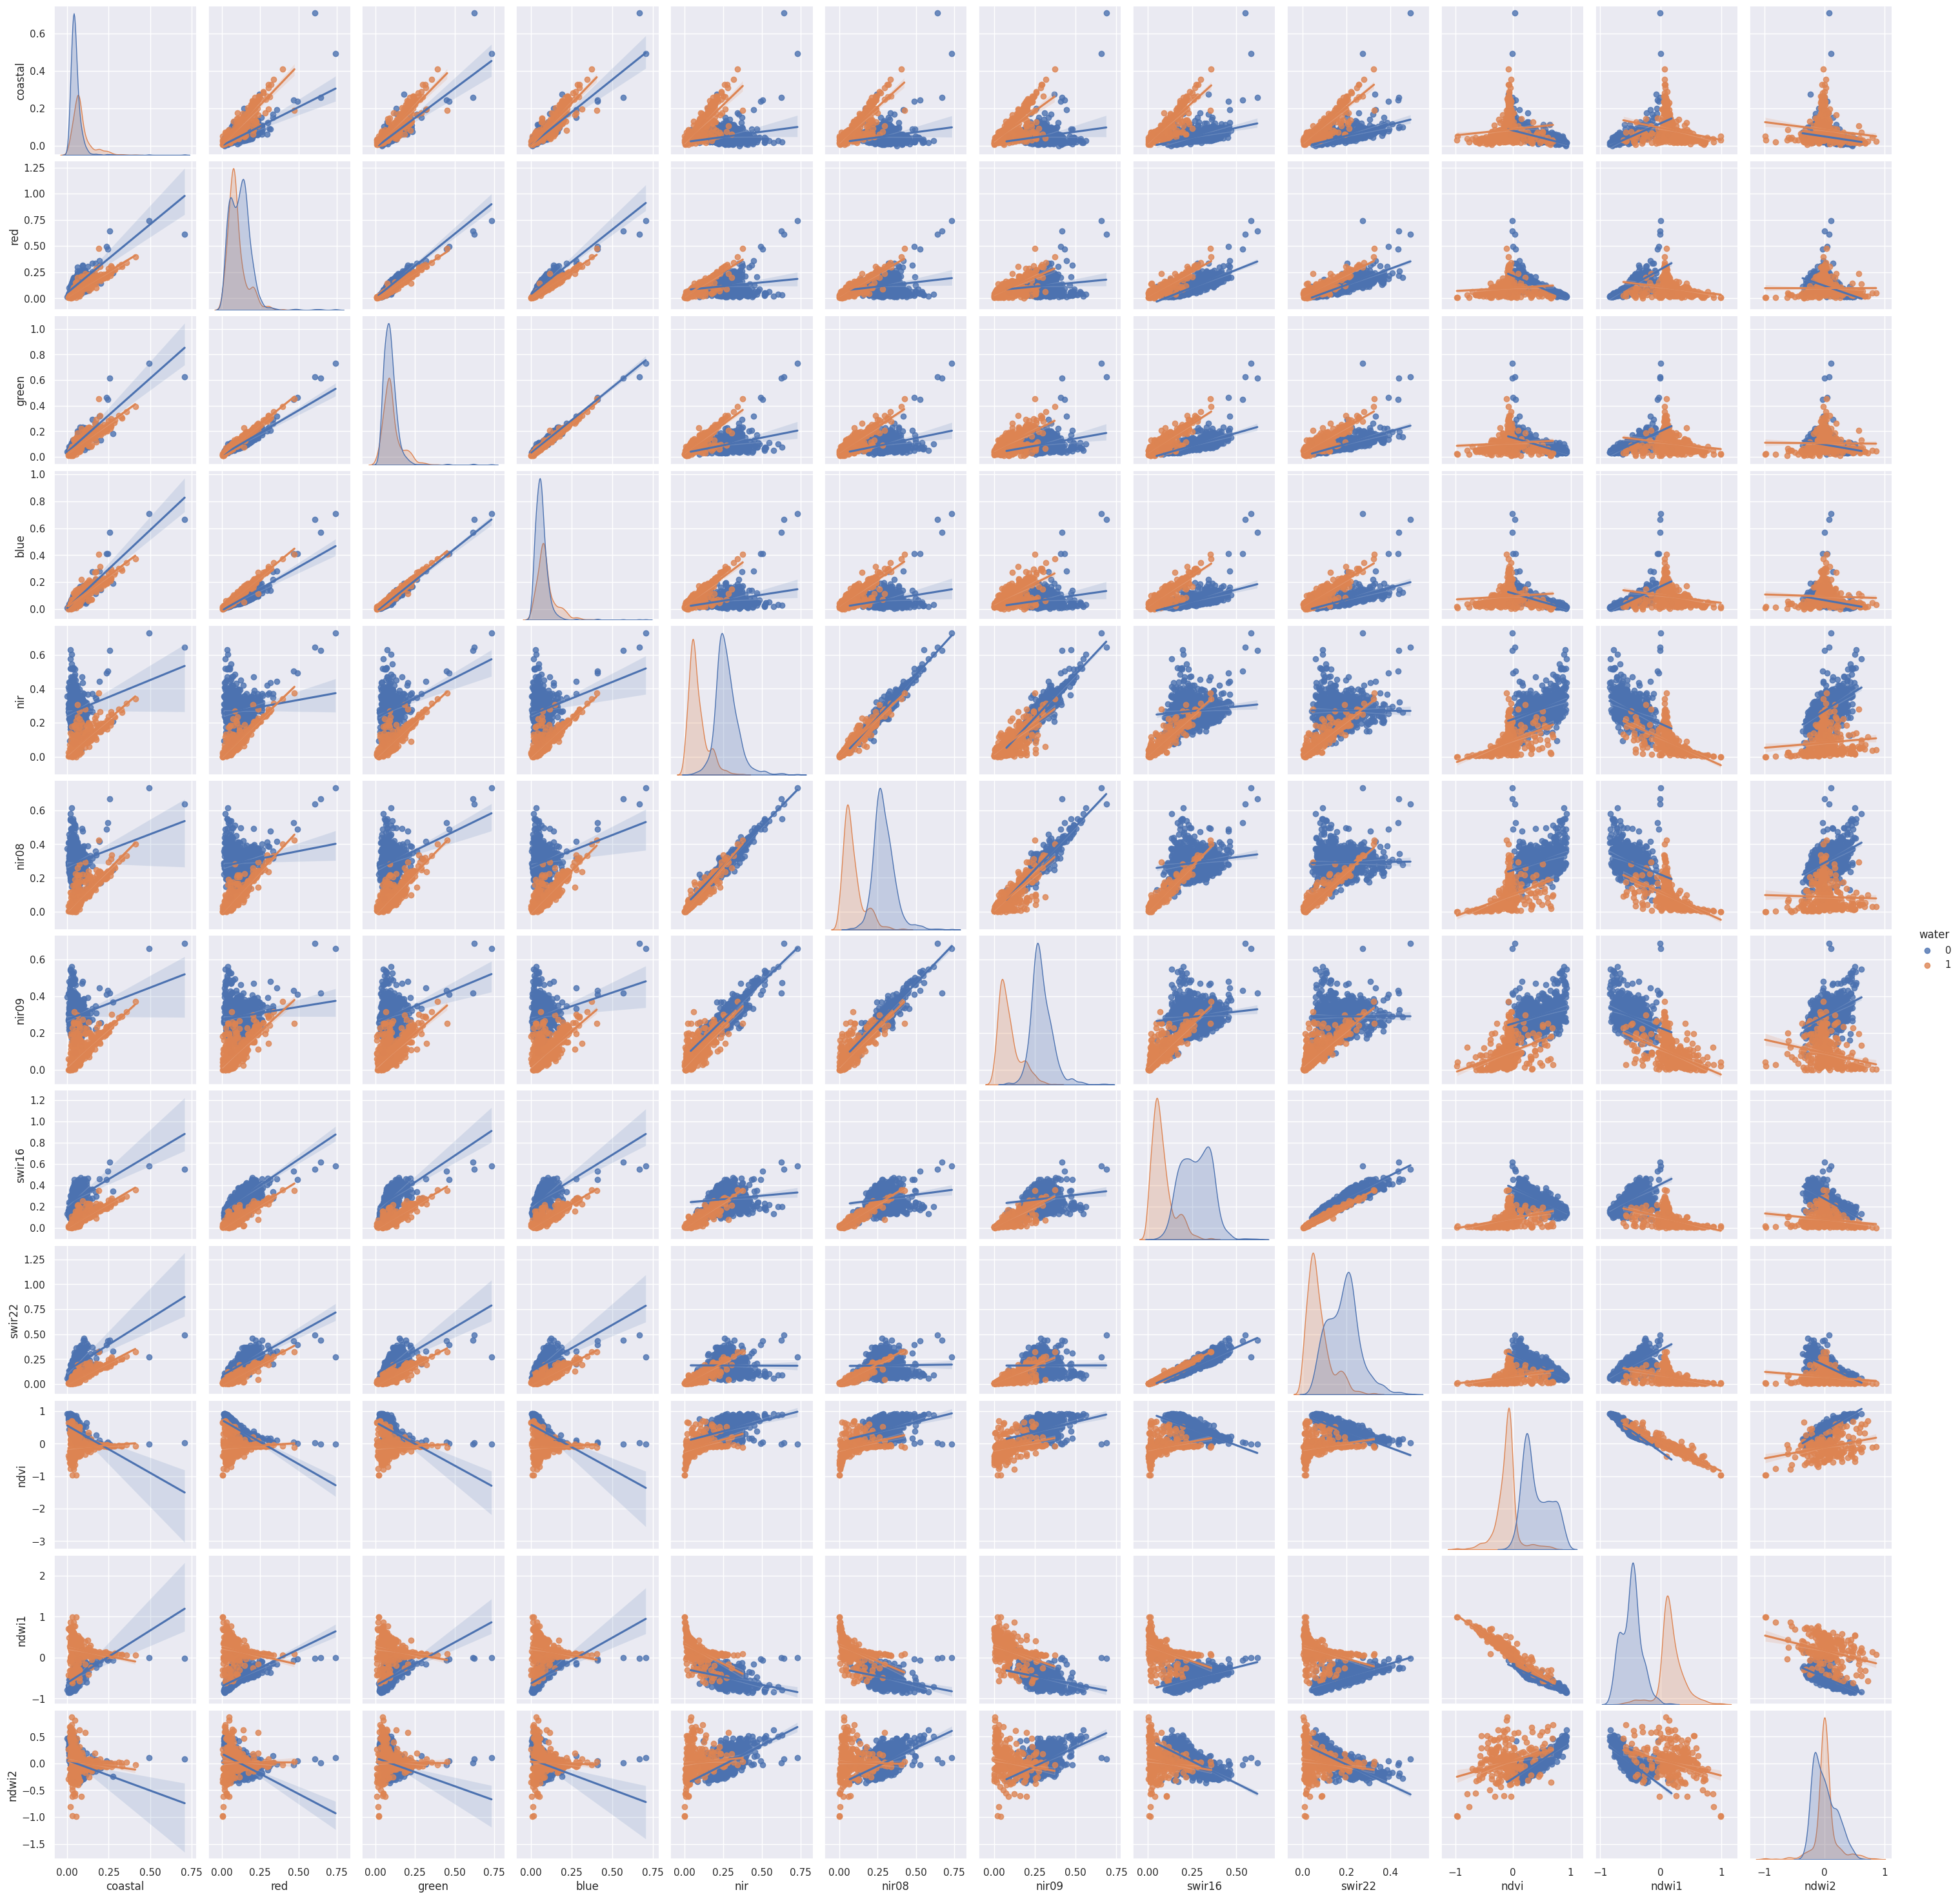

In [11]:
sns.set()
sns.pairplot(dataset, hue=LABEL_NAME, kind='reg')
plt.savefig('output/img_test.png')

### 5.2 Distribution for each channel

Another good practice is to understand the distribution of values for each column feature. This will show you where most of your data lives for each feature in the dataset, including the distribution of training labels.

array([[<Axes: title={'center': 'coastal'}>,
        <Axes: title={'center': 'red'}>,
        <Axes: title={'center': 'green'}>,
        <Axes: title={'center': 'blue'}>],
       [<Axes: title={'center': 'nir'}>,
        <Axes: title={'center': 'nir08'}>,
        <Axes: title={'center': 'nir09'}>,
        <Axes: title={'center': 'swir16'}>],
       [<Axes: title={'center': 'swir22'}>,
        <Axes: title={'center': 'ndvi'}>,
        <Axes: title={'center': 'ndwi1'}>,
        <Axes: title={'center': 'ndwi2'}>],
       [<Axes: title={'center': 'water'}>, <Axes: >, <Axes: >, <Axes: >]],
      dtype=object)

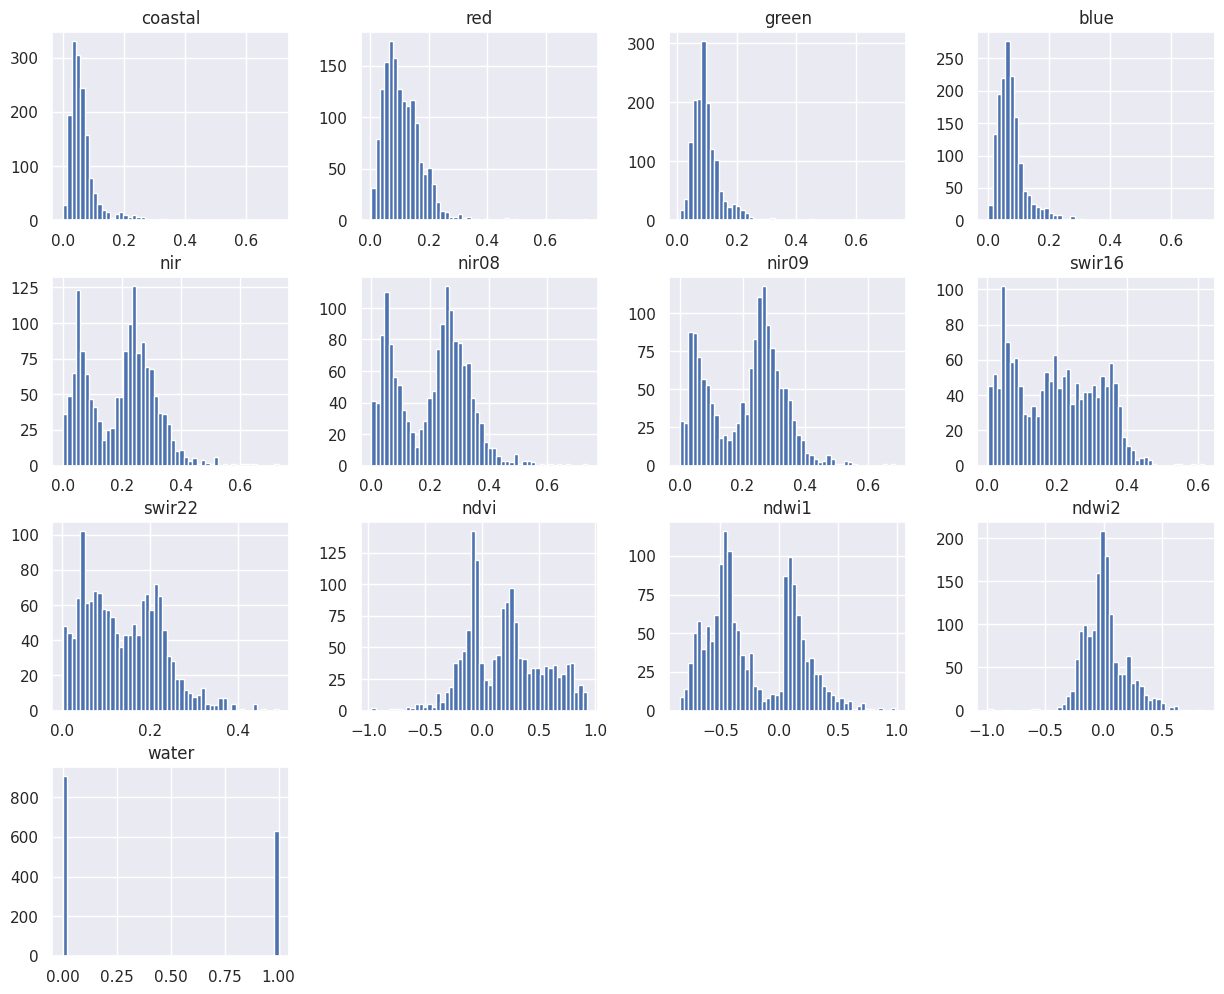

In [12]:
dataset.hist(figsize=(15, 12), bins=50)

### 5.3 Correlation calculations

Here we can do a more statistical approach to correlation using pandas corr() function.

In [13]:
# correlation with dataset - target value
corr = dataset.corr()[LABEL_NAME]
corr.to_csv('output/correlation.csv')
corr

coastal    0.346188
red       -0.158800
green      0.099658
blue       0.254369
nir       -0.806054
nir08     -0.821762
nir09     -0.831830
swir16    -0.784988
swir22    -0.645787
ndvi      -0.757744
ndwi1      0.872270
ndwi2      0.034941
water      1.000000
Name: water, dtype: float64

In [14]:
# full correlation table
dataset.corr().style.background_gradient(cmap='viridis')

,coastal,red,green,blue,nir,nir08,nir09,swir16,swir22,ndvi,ndwi1,ndwi2,water
coastal,1.000000,0.675126,0.849188,0.904356,-0.021842,-0.012337,-0.050436,0.069064,0.256249,-0.385004,0.363828,-0.153514,0.346188
red,0.675126,1.000000,0.909562,0.836837,0.361717,0.376343,0.328584,0.635780,0.737399,-0.200213,0.016308,-0.344022,-0.158800
green,0.849188,0.909562,1.000000,0.974001,0.236544,0.234967,0.171563,0.357043,0.501580,-0.286984,0.206106,-0.165160,0.099658
blue,0.904356,0.836837,0.974001,1.000000,0.076804,0.075655,0.017425,0.202593,0.370794,-0.390058,0.333726,-0.170185,0.254369
nir,-0.021842,0.361717,0.236544,0.076804,1.000000,0.988179,0.952923,0.760891,0.641139,0.766080,-0.826165,0.209640,-0.806054
nir08,-0.012337,0.376343,0.234967,0.075655,0.988179,1.000000,0.967242,0.791488,0.671441,0.757183,-0.829893,0.144255,-0.821762
nir09,-0.050436,0.328584,0.171563,0.017425,0.952923,0.967242,1.000000,0.779825,0.654926,0.752712,-0.826755,0.087794,-0.831830
swir16,0.069064,0.635780,0.357043,0.202593,0.760891,0.791488,0.779825,1.000000,0.947554,0.427829,-0.634494,-0.359405,-0.784988
swir22,0.256249,0.737399,0.501580,0.370794,0.641139,0.671441,0.654926,0.947554,1.000000,0.258939,-0.465183,-0.434632,-0.645787
ndvi,-0.385004,-0.200213,-0.286984,-0.390058,0.766080,0.757183,0.752712,0.427829,0.258939,1.000000,-0.953707,0.411782,-0.757744


## 5.4 Another Look at Distributions

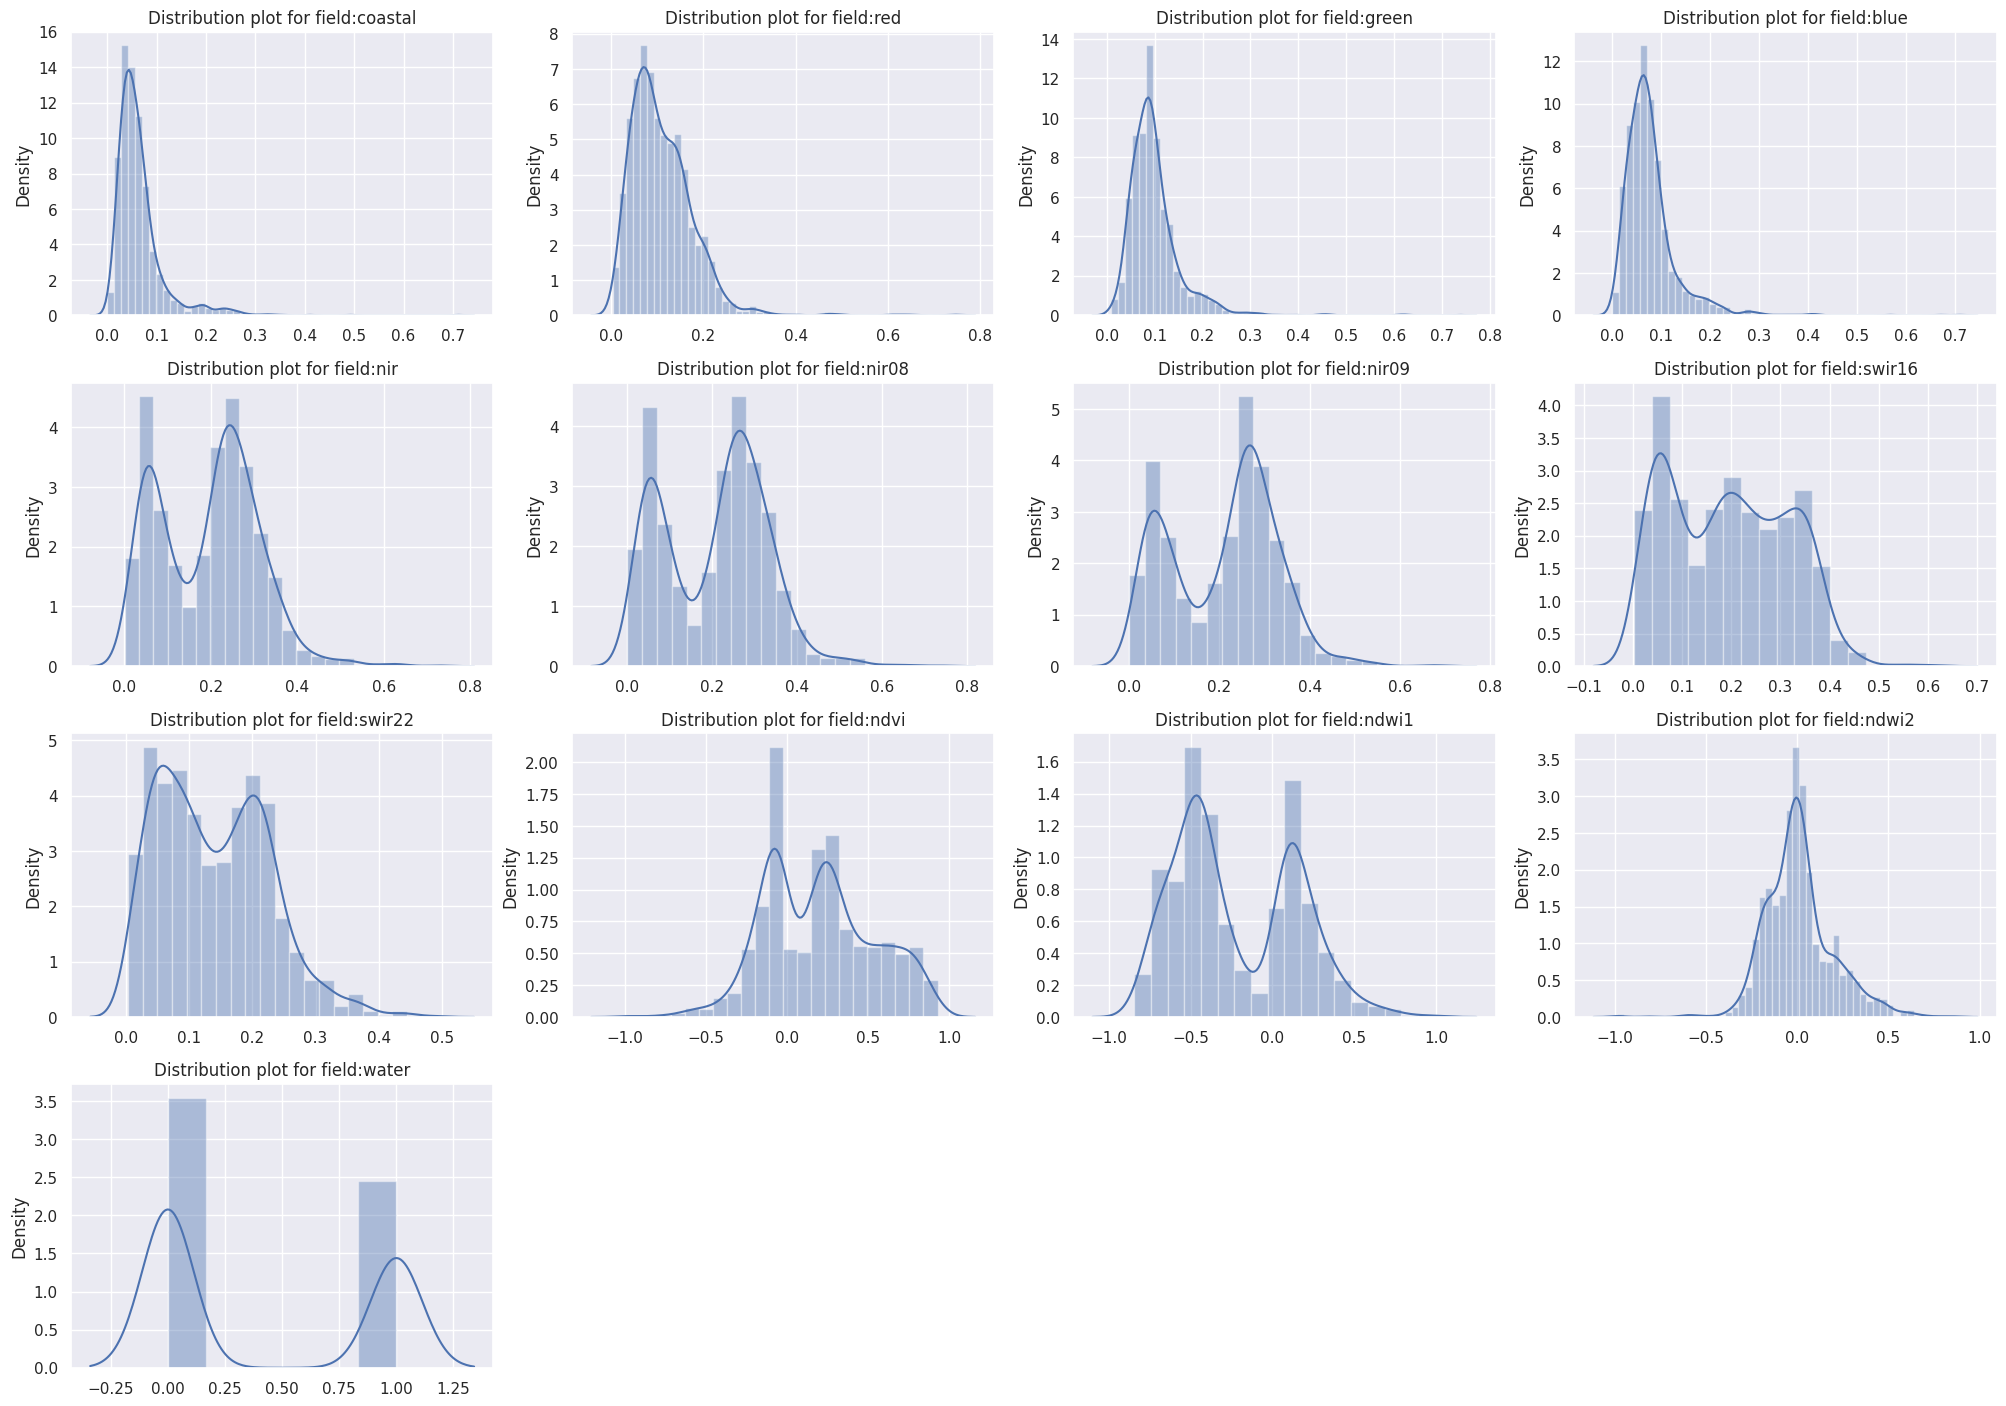

In [15]:
plt.figure(figsize=(20, 14))

for i, c in enumerate(dataset.select_dtypes(include='number').columns):
    plt.subplot(4,4,i+1)
    sns.distplot(dataset[c])
    plt.title('Distribution plot for field:' + c)
    plt.xlabel('')
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.savefig('output/output_dist_s2_water.png')

We can also target specifically the distribution of specific features when related to the corresponding label.

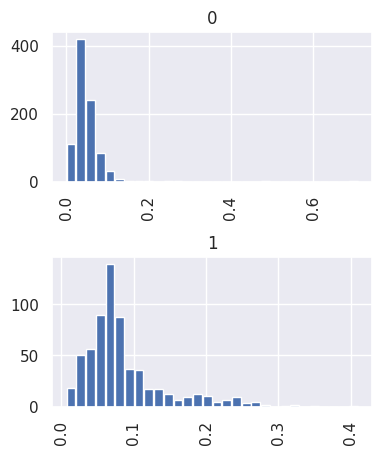

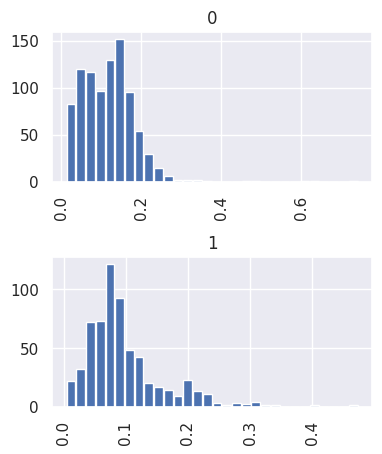

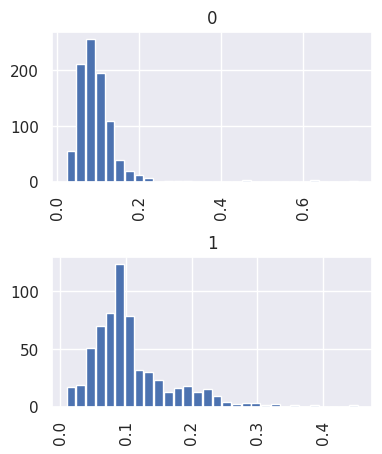

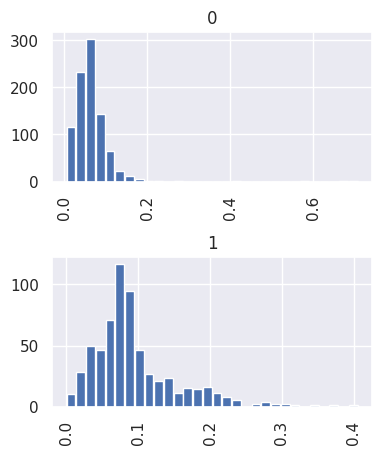

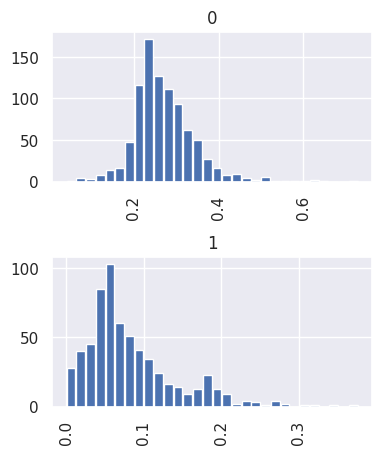

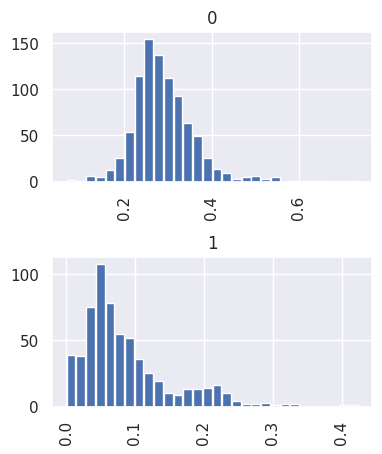

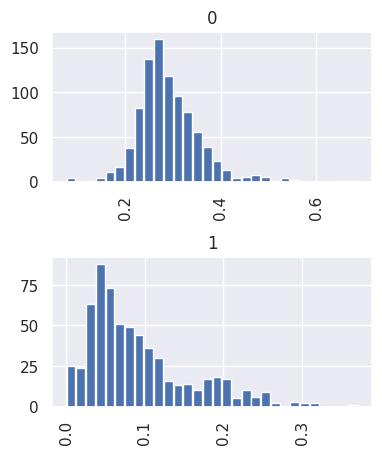

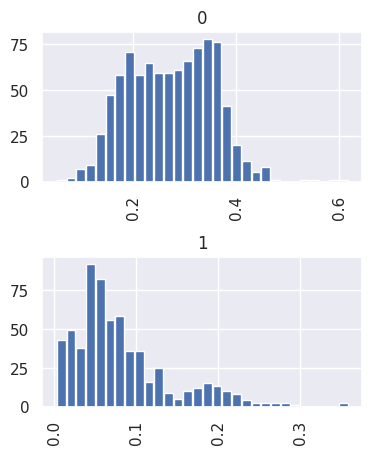

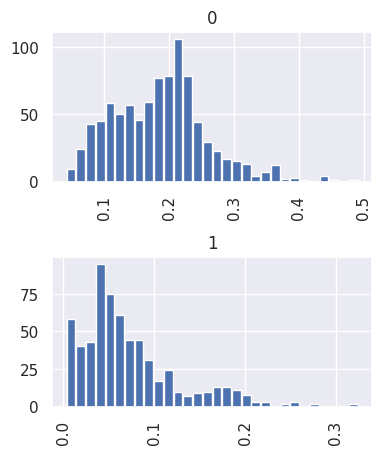

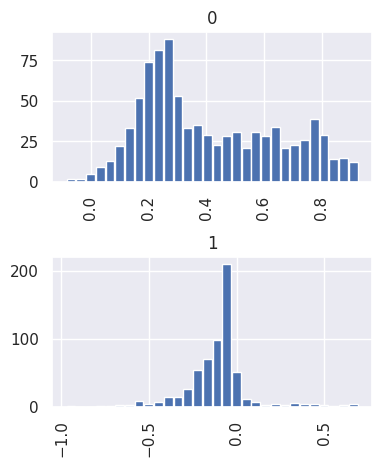

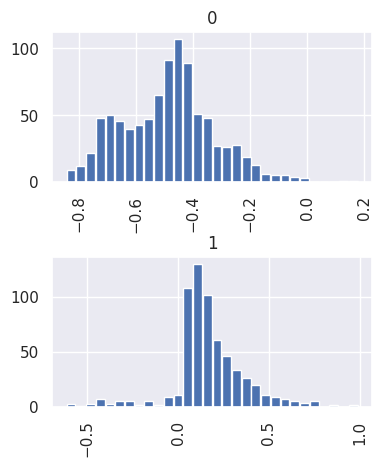

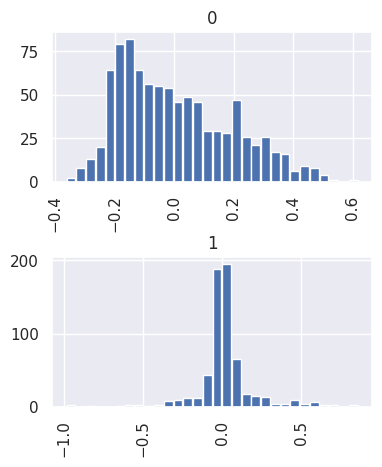

In [25]:
for i, c in enumerate(dataset.select_dtypes(include='number').columns):
    if c == LABEL_NAME: continue
    dataset.hist(column=c, by=LABEL_NAME, bins=30, grid=True, figsize=(4, 5), layout=(2, 1), zorder=2, rwidth=0.9, sharex=False)

### 5.5 Outlier Detection¶

Finding outliers using the Tukey IQR method: the Tukey IQR rule says that the outliers are values more than 1.5 times the interquartile range from the quartiles — either below Q1 − 1.5 IQR, or above Q3 + 1.5IQR. Thus we can simply calculate outliers per column feature by taking the necessary percentiles.

In [17]:
def find_outliers_tukey(x):
    q1 = np.percentile(x,25)
    q3 = np.percentile(x,75)
    iqr = q3 - q1
    floor = q1 - 1.5*iqr
    ceiling = q3 + 1.5*iqr
    outlier_indices = list(x.index[(x<floor) | (x>ceiling)])
    outlier_values = list(x[outlier_indices])
    
    return outlier_indices,outlier_values

For example, outliers from ndwi2 are listed below:

In [18]:
tukey_indices,tukey_values = find_outliers_tukey(dataset['ndwi2'])
np.sort(tukey_values)

array([-0.98709677, -0.97727273, -0.81081081, -0.6196319 , -0.6196319 ,
       -0.6196319 , -0.61344538, -0.60059835, -0.60059835, -0.56976744,
       -0.56976744, -0.54861111, -0.54861111, -0.54861111, -0.4962963 ,
       -0.43603133, -0.37215909, -0.3573701 , -0.32984293, -0.32682927,
       -0.29319781, -0.29188256, -0.29188256, -0.28813559, -0.25824079,
       -0.25294852, -0.25234777, -0.25028835, -0.24568844, -0.24142615,
       -0.24142615, -0.2278481 , -0.22736286, -0.22731085, -0.22622951,
       -0.22621902, -0.22544223, -0.22372567, -0.22372567, -0.22218169,
       -0.22107304, -0.22058575, -0.21789137, -0.21733668, -0.21557178,
       -0.20697724, -0.20676016, -0.20491174, -0.20028234, -0.19207921,
       -0.19193428, -0.19193428, -0.19152855, -0.19101124, -0.18981324,
       -0.18880583, -0.18594748, -0.18508655, -0.18495704, -0.18421053,
       -0.17875458, -0.17328223, -0.17309326, -0.17042643, -0.16769938,
       -0.15838365, -0.15838365, -0.15627728, -0.14992459, -0.14

## 5.6 Feature Engineering, Creating New Features

Future engineering can be used where the available features are not enough for the ML model (eg a small number of features is available, or it is not representative enough). Future engineering can be used in such cases to increase and/or improve our dataset representativeness


In [19]:
def add_interactions(df):
    combos = list(combinations(list(df.columns),2))
    colnames = list(df.columns) + ['_'.join(x) for  x in combos]
    
    poly = PolynomialFeatures(interaction_only=True, include_bias=False)
    df = poly.fit_transform(df)
    df = pd.DataFrame(df)
    df.columns = colnames
    
    noint_indicies = [i for i, x in enumerate(list((df == 0).all())) if x]
    df = df.drop(df.columns[noint_indicies], axis= 1)
    
    return df

In this function we simply produce combinations of each band that increases out feature space from 10 to 65. For an algorithm like a random forest where decisions are being made, this could provide a substantial improvement. Algorithms like convolutional neural networks might not need these since they can extract patterns directly out of the data.

In [20]:
interactions = add_interactions(dataset)
interactions.head()

,coastal,red,green,blue,nir,nir08,nir09,swir16,swir22,ndvi,...,swir22_ndvi,swir22_ndwi1,swir22_ndwi2,swir22_water,ndvi_ndwi1,ndvi_ndwi2,ndvi_water,ndwi1_ndwi2,ndwi1_water,ndwi2_water
0,0.0213,0.0269,0.0548,0.0271,0.2324,0.2377,0.1979,0.0934,0.0444,0.792518,...,0.035188,-0.027456,0.018943,0.0,-0.490081,0.338122,0.0,-0.263829,-0.0,0.0
1,0.0201,0.0247,0.0367,0.0217,0.2316,0.2387,0.2374,0.1397,0.0743,0.807257,...,0.059979,-0.053973,0.018390,0.0,-0.586412,0.199803,0.0,-0.179797,-0.0,0.0
2,0.2738,0.2448,0.1814,0.1920,0.2098,0.2458,0.3692,0.3419,0.3275,-0.076991,...,-0.025214,-0.023776,-0.078417,0.0,0.005589,0.018435,-0.0,0.017383,-0.0,-0.0
3,0.0309,0.1086,0.0664,0.0473,0.2058,0.2451,0.2392,0.3256,0.2189,0.309160,...,0.067675,-0.112104,-0.049349,0.0,-0.158328,-0.069698,0.0,0.115454,-0.0,-0.0
4,0.0276,0.0405,0.0745,0.0384,0.3708,0.3878,0.3803,0.1959,0.0954,0.803063,...,0.076612,-0.063479,0.029443,0.0,-0.534354,0.247849,0.0,-0.205360,-0.0,0.0


## 5.7 Dimensionality reduction using PCA

PCA is a tecnique that transforms a dataset of many features into principal components that summarize the variance that underlies the data. This can also be used to extract the principal components from each feature so they can be used in training.

In [21]:
dataset.columns

Index(['coastal', 'red', 'green', 'blue', 'nir', 'nir08', 'nir09', 'swir16',
       'swir22', 'ndvi', 'ndwi1', 'ndwi2', 'water'],
      dtype='object')

In [22]:
pca = PCA(n_components=len(dataset.columns))
X_pca = pd.DataFrame(pca.fit_transform(dataset))
X_pca.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,-0.748843,0.516406,-0.123192,-0.173195,-0.016715,0.121403,-0.018022,0.020574,0.009955,0.011179,0.008438,0.011303,0.000842
1,-0.818029,0.425568,-0.145788,0.008333,-0.017176,0.083798,0.005572,0.004430,0.010238,0.004786,-0.000226,0.002602,-0.003280
2,-0.127355,-0.630691,0.152560,-0.117744,0.022382,0.107271,0.054529,-0.153752,-0.054027,0.017975,-0.018142,0.011126,-0.020420
3,-0.502620,-0.246289,-0.118919,0.138538,-0.054694,-0.025798,0.004502,0.004872,-0.007703,0.005591,0.007590,-0.012162,-0.000519
4,-0.858510,0.408458,0.060074,-0.055487,0.119155,-0.000847,-0.022699,0.007933,0.007476,0.012066,0.000645,-0.004838,0.004489
